<a href="https://colab.research.google.com/github/brlnoble/Image_Encoder-Decoder/blob/main/4TN4_Project2_Attempt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install dependencies**

In [ ]:
!pip install tensorflow #For building CNN
!pip install numpy #For arrays
!pip install opencv-python #Image read/write
!pip install tqdm #For displaying progress
!pip install matplotlib #For showing images
#!pip install glob #For accessing files on Google Drive

# **Import libraries**

In [ ]:
from tensorflow.keras.layers import * #CNN construction
from tensorflow.keras.models import * #CNN construction
import cv2 #image read/write functionality
import numpy as np #arrays and stuff
from tqdm import tqdm #progress timing
import matplotlib.pyplot as plt #for displaying images
from google.colab import drive #for using Google Drive
from glob import glob #for using Google Drive

# **Function Definitions**

In [ ]:
def Get_Model():
  input = Input(shape=(None,None,1))

  x = Conv2D(32,3, activation="relu", padding="same")(input)
  x = Conv2D(64,3, activation="relu", padding="same")(x)
  x = Conv2D(128,3, activation="relu", padding="same")(x)
  x = Conv2D(256,3, activation="relu", padding="same")(x)
  x = UpSampling2D(2)(x)
  x = Conv2D(128,3, activation="relu", padding="same")(x)
  x = Conv2D(64,3, activation="relu", padding="same")(x)
  x = Conv2D(32,3, activation="tanh", padding="same")(x) #using tanh for the final layer
  x = Conv2D(1,3, activation=None, padding="same")(x)
  
  x = x*255.0 #Scale back to be within 0 - 255
  

  model = Model([input],x)
  model.summary()
  return model


def Get_Data(selection,scale,channel):
  x = []
  y = []
 
  train_path = "/content/drive/MyDrive/SCHOOL/Year 5 6/DIV2K/Train/*.png"
  valid_path = "/content/drive/MyDrive/SCHOOL/Year 5 6/DIV2K/Validate/*.png"

  #Select whether we are grabbing the train or validation data
  if selection == "train":
    img_path = train_path
  else:
    img_path = valid_path

  print(f"~~~~~~~~~~ Accessing {selection} data for {channel} channel ~~~~~~~~~~")

  #Resize and add all the images to an array
  for img_dir in tqdm(glob(img_path)):
    img = cv2.imread(img_dir)
    img_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

    #Separate the Y U V channels
    if channel == "Y":
      luma = img_yuv[:,:,0]
      luma_out = cv2.resize(luma,(408,280),interpolation=cv2.INTER_AREA)
      luma_in = cv2.resize(luma_out,(204,140),interpolation=cv2.INTER_AREA)

      x.append(luma_in)
      y.append(luma_out)

    elif channel == "U":
      blue = img_yuv[:,:,1]
      blue_out = cv2.resize(blue,(408,280),interpolation=cv2.INTER_AREA)
      blue_in = cv2.resize(blue_out,(102,70),interpolation=cv2.INTER_AREA)

      x.append(blue_in)
      y.append(blue_out)
    
    else:
      red = img_yuv[:,:,2]
      red_out = cv2.resize(red,(408,280),interpolation=cv2.INTER_AREA)
      red_in = cv2.resize(red_out,(102,70),interpolation=cv2.INTER_AREA)

      x.append(red_in)
      y.append(red_out)

  #Change to numpy arrays
  x = np.array(x)
  y = np.array(y)

  return x,y


# **Generate Training Data**

In [ ]:
#Mount Google Drive to Colab so it can be used
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Create the training data
x_train_y,y_train_y = Get_Data("train",0.2,"Y")
x_train_u,y_train_u = Get_Data("train",0.2,"U")
x_train_v,y_train_v = Get_Data("train",0.2,"V")
print(f"""~~~~~~~~~~ Training Data ~~~~~~~~~~\n
  Y-Channel:\tX: {x_train_y.shape}\tY: {y_train_y.shape}
  U-Channel:\tX: {x_train_u.shape}\tY: {y_train_u.shape}
  V-Channel:\tX: {x_train_v.shape}\tY: {y_train_v.shape}
""")

#Create the validation data
x_valid_y,y_valid_y = Get_Data("valid",0.2,"Y")
x_valid_u,y_valid_u = Get_Data("valid",0.2,"U")
x_valid_v,y_valid_v = Get_Data("valid",0.2,"V")
print(f"""~~~~~~~~~~ Validation Data ~~~~~~~~~~\n
  Y-Channel:\tX: {x_valid_y.shape}\tY: {y_valid_y.shape}
  U-Channel:\tX: {x_valid_u.shape}\tY: {y_valid_u.shape}
  V-Channel:\tX: {x_valid_v.shape}\tY: {y_valid_v.shape}
""")


import matplotlib.pyplot as plt

plt.subplot(211)
plt.imshow(x_train_y[0],cmap='gray')
plt.subplot(232)
plt.imshow(x_train_u[0],cmap='gray')
plt.subplot(233)
plt.imshow(x_train_v[0],cmap='gray')

plt.subplot(212)
plt.imshow(x_valid_y[0],cmap='gray')
plt.subplot(235)
plt.imshow(x_valid_u[0],cmap='gray')
plt.subplot(236)
plt.imshow(x_valid_v[0],cmap='gray')
plt.show()

In [ ]:
#Gets the models
y_model = Get_Model() #For the Y channel

# Train the Y Channel Model

In [ ]:
#~~~~~ Trains the model Y~~~~~

import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) #hyper parameter, 1e-4 working well
loss = 'mse' #working well, no reason to change
y_model.compile(loss=loss,optimizer=optimizer)

#Figure out what number this model should be
num = len(glob("/content/drive/MyDrive/SCHOOL/Year 5 6/DIV2K/Models/*.h5"))

#Setup when the model should be saved
save_model_callback = tf.keras.callbacks.ModelCheckpoint(
    f"/content/drive/MyDrive/SCHOOL/Year 5 6/DIV2K/Models/model{num}.h5",
    monitor='val_loss', #monitor the loss function
    verbose=1,
    save_best_only=True, #ensures results do not get worse
    mode='min', #minimizing loss function
    save_freq='epoch' #save after each epoch is completed
)

batch_size=4 #parameter
epochs=100 #parameter

#Train the model
y_model.fit(x_train_y,y_train_y,validation_data=(x_valid_y,y_valid_y),batch_size=batch_size,epochs=epochs,validation_split=0.1,callbacks=save_model_callback)

# Train the UV Channel Model

In [ ]:
#~~~~~ Trains the model UV~~~~~

import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) #hyper parameter, 1e-4 working well
loss = 'mse' #working well, no reason to change
uv_model.compile(loss=loss,optimizer=optimizer)

#Figure out what number this model should be
num = len(glob("/content/drive/MyDrive/SCHOOL/Year 5 6/DIV2K/Models/*.h5"))

#Setup when the model should be saved
save_model_callback = tf.keras.callbacks.ModelCheckpoint(
    f"/content/drive/MyDrive/SCHOOL/Year 5 6/DIV2K/Models/uv_model{num}.h5",
    monitor='val_loss', #monitor the loss function
    verbose=1, #Show progress bar per epoch
    save_best_only=True, #ensures results do not get worse
    mode='min', #minimizing loss function
    save_freq='epoch' #save after each epoch is completed
)

batch_size=4 #parameter
epochs=10 #parameter

#Train the model
uv_model.fit(x_train_u,y_train_u,validation_data=(x_valid_u,y_valid_u),batch_size=batch_size,epochs=epochs,validation_split=0.1,callbacks=save_model_callback)

# **Run the Model on a Selected Image**

1/1 [==============================] - 0s 18ms/step
(1, 272, 408, 1)
(272, 408)


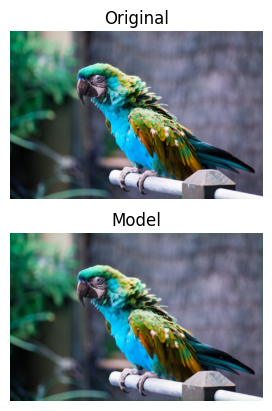

In [ ]:
#For manually selecting model, change below, otherwise it will select the newest
#num = 20

#print("~"*50 + f"\nLoading model #{num}\n" + "~"*50 + "\n")
y_model = load_model(f"/content/drive/MyDrive/SCHOOL/Year 5 6/DIV2K/Models/model20.h5")
#uv_model = load_model(f"/content/drive/MyDrive/SCHOOL/Year 5 6/DIV2K/Models/uv_model{num}.h5")  
#model 20 is the best. val_loss = 84.67756 at 100 epoch, 775,425 parameters

img = cv2.imread("/content/drive/MyDrive/SCHOOL/Year 5 6/DIV2K/Validate/0886.png")
img_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
img_yuv = cv2.resize(img_yuv,None,fx=0.2,fy=0.2,interpolation=cv2.INTER_AREA) #Resize image because it is 2k

luma = img_yuv[:,:,0]
blue = img_yuv[:,:,1]
red = img_yuv[:,:,2]

#~~~~~ Resize the channels ~~~~~~
luma_in = cv2.resize(luma, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA) #Replace with my downsampling function
blue_in = cv2.resize(blue, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA) #Replace with my downsampling function
red_in = cv2.resize(red, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA) #Replace with my downsampling function

luma_in = np.expand_dims(luma_in,axis=0)
blue_in = np.expand_dims(blue_in,axis=0)
red_in = np.expand_dims(red_in,axis=0)

#~~~~~~ Upsample the channels ~~~~~
luma_up = np.array(y_model.predict(luma_in))

blue_up = y_model.predict(blue_in) #Run twice since the model upsamples by x2
blue_up = np.array(y_model.predict(blue_up))

red_up = y_model.predict(red_in)
red_up = np.array(y_model.predict(red_up)) #Run twice since the model upsamples by x2

#~~~~~ Get images ready for display ~~~~~
orig_img = cv2.cvtColor(img_yuv,cv2.COLOR_YUV2BGR)

up_img = np.zeros((272,408,3),dtype=np.uint8)
print(blue_up.shape)
print(blue_up[0][:,:,0].shape)
up_img[:,:,0] = luma_up[0][:,:,0]
up_img[:,:,1] = blue_up[0][:,:,0]
up_img[:,:,2] = red_up[0][:,:,0]
up_img = cv2.cvtColor(up_img,cv2.COLOR_YUV2BGR)

#Graph the result
plt.subplot(211)
plt.imshow(orig_img)
plt.gca().set_title('Original')
plt.axis('off')
plt.subplot(212)
plt.imshow(up_img)
plt.gca().set_title('Model')
plt.axis('off')
plt.show()